In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from xml.dom import minidom
print("Modules imported")

Modules imported


In [31]:
def get_activity_data(tcx_string):
    """
    Constructs a pandas dataframe from the TCX file passed
    """
    mydoc = minidom.parse(tcx_string)
    trkpt = mydoc.getElementsByTagName("Trackpoint")
    column_names = ["timestamp", "latitude", "longitude", "distance", "elevation",
                    "heart_rate", "cadence", "power", "speed"]
    row_list = []

    # parse trackpoint elements. Search for child elements in each trackpoint so they stay in sync.
    for elem in trkpt:
        etimestamp = elem.getElementsByTagName("Time")
        timestamp = None
        for selem in etimestamp:
            timestamp = selem.firstChild.data

        epos = elem.getElementsByTagName("Position")
        elat = None
        elng = None
        for selem in epos:
            elat = selem.getElementsByTagName("LatitudeDegrees")
            lat = None
            for sselem in elat:
                lat = sselem.firstChild.data
            elng = selem.getElementsByTagName("LongitudeDegrees")
            lng = None
            for sselem in elng:
                lng = sselem.firstChild.data

        eelevation = elem.getElementsByTagName("AltitudeMeters")
        elevation = 0.0
        for selem in eelevation:
            elevation = selem.firstChild.data
        
        edistance = elem.getElementsByTagName("DistanceMeters")
        distance = 0.0
        for selem in edistance:
            distance = selem.firstChild.data

        eheart = elem.getElementsByTagName("HeartRateBpm")
        eheart_rate = None
        heart_rate = 0
        for selem in eheart:
            eheart_rate = selem.getElementsByTagName("Value")
            for sselem in eheart_rate:
                heart_rate = sselem.firstChild.data

        ecad = elem.getElementsByTagName("Cadence")
        cadence = 0.0
        for selem in ecad:
            cadence = selem.firstChild.data

        eextensions = elem.getElementsByTagName("Extensions")
        ens3 = None
        for selem in eextensions:
            ens3 = selem.getElementsByTagName("ns3:TPX")
            espeed = None
            epower = None
            for sselem in ens3:
                espeed = sselem.getElementsByTagName("ns3:Speed")
                speed = 0.0
                for ssselem in espeed:
                    speed = ssselem.firstChild.data
                epower = sselem.getElementsByTagName("ns3:Watts")
                power = 0.0
                for ssselem in epower:
                    power = ssselem.firstChild.data

        this_row = [timestamp, lat, lng, float(distance), float(elevation), 
                    float(heart_rate), float(cadence), float(power), float(speed)]
        row_list.append(this_row)

    df = pd.DataFrame(row_list, columns=column_names)
    return df
df1 = get_activity_data('Cville10272020.tcx')
df2 = get_activity_data('Bburg10232020.tcx')
df3 = get_activity_data('Bburg09202020.tcx')
df4 = get_activity_data('Luray10312020.tcx')
df5 = get_activity_data('Luray11142020.tcx')
df6 = get_activity_data('DuPage11282020.tcx')

In [32]:
def getdata(df):
    cad = df["cadence"].to_numpy()
    pwr = df["power"].to_numpy()
    elv = df["elevation"].to_numpy()
    dst = df["distance"].to_numpy()
    spd = df["speed"].to_numpy()
    hrt = df["heart_rate"].to_numpy()
    
    # Compute gradient
    delta_elv = np.gradient(elv)
    delta_dst = np.gradient(dst)
    for i in range(0, len(delta_dst) - 1):
        if(delta_dst[i] <= 0):              #checking current element 
            if(i == 0):                     #checking case for first elt == 0  
                j = 0
                while(delta_dst[i] <= 0):        #finding first non zero elt
                    if(delta_dst[j] > 0):
                        delta_dst[i] = delta_dst[j]    #setting equal to that elt 
                    j+=1
            else:
                delta_dst[i] = delta_dst[i - 1]
    grd = 100*np.divide(delta_elv, delta_dst)
    return cad,pwr,grd,hrt  


cad1,pwr1,grd1,hrt1 = getdata(df1) 
cad2,pwr2,grd2,hrt2 = getdata(df2) 
cad3,pwr3,grd3,hrt3 = getdata(df3)
cad4,pwr4,grd4,hrt4 = getdata(df4)
cad5,pwr5,grd5,hrt5 = getdata(df5)
cad6,pwr6,grd6,hrt6 = getdata(df6)

C:\Users\rouna\anaconda3\envs\rounak\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


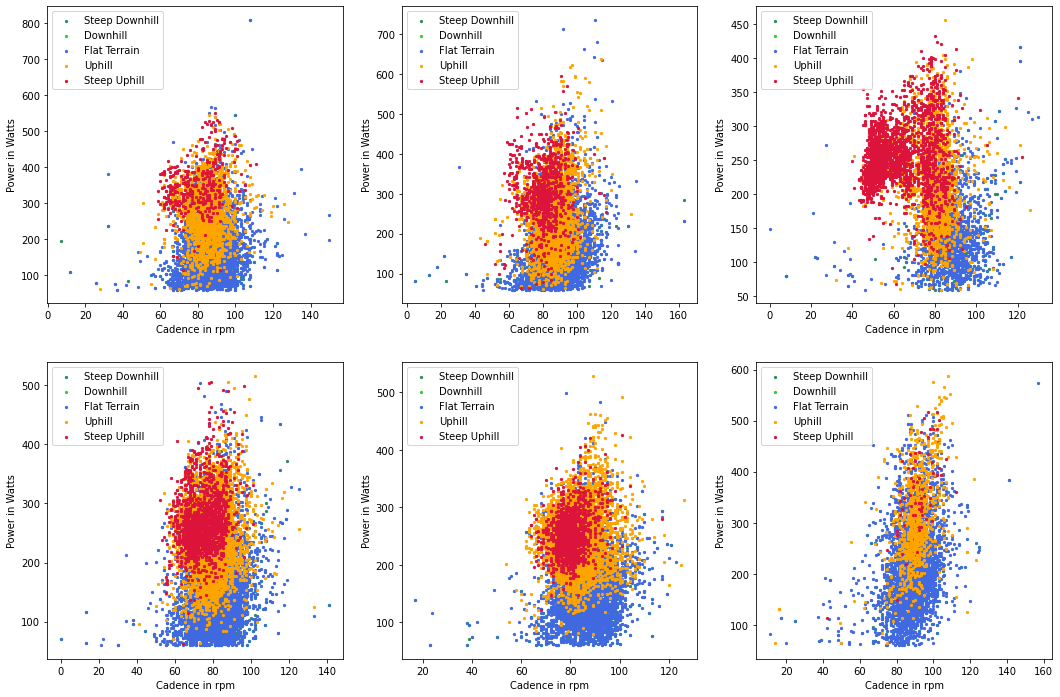

In [33]:
def clean(cad, pwr, grd):
    ind = np.where(pwr < 60)
    pwr_c = np.delete(pwr, ind)
    cad_c = np.delete(cad, ind)
    grd_c = np.delete(grd, ind)
    return pwr_c, cad_c, grd_c

# Clustering the power-cadence scatter plot based on the elevation grade
def cluster_grade(cad,pwr,grd,ax):
    ind_1 = np.where(grd<-8.0)
    ind_2 = np.where((grd<=-2.0) & (-8.0<=grd))
    ind_3 = np.where((-8.0<grd)&(grd<2.0))
    ind_4 = np.where((2.0<=grd)&(grd<=8.0))
    ind_5 = np.where(8.0<grd)
    ax.scatter(cad[ind_1],pwr[ind_1],c='seagreen',s=5.0,label="Steep Downhill")
    ax.scatter(cad[ind_2],pwr[ind_2],c='limegreen',s=5.0,label="Downhill")
    ax.scatter(cad[ind_3],pwr[ind_3],c='royalblue',s=5.0,label="Flat Terrain")
    ax.scatter(cad[ind_4],pwr[ind_4],c='orange',s=5.0,label="Uphill")
    ax.scatter(cad[ind_5],pwr[ind_5],c='crimson',s=5.0,label="Steep Uphill")
    ax.set_xlabel("Cadence in rpm")
    ax.set_ylabel("Power in Watts")
    ax.legend()
    return


pwr_c1,cad_c1,grd_c1 = clean(cad1,pwr1,grd1)
pwr_c2,cad_c2,grd_c2 = clean(cad2,pwr2,grd2)
pwr_c3,cad_c3,grd_c3 = clean(cad3,pwr3,grd3)
pwr_c4,cad_c4,grd_c4 = clean(cad4,pwr4,grd4)
pwr_c5,cad_c5,grd_c5 = clean(cad5,pwr5,grd5)
pwr_c6,cad_c6,grd_c6 = clean(cad6,pwr6,grd6)


fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
cluster_grade(cad_c1,pwr_c1,grd_c1,ax1)
cluster_grade(cad_c2,pwr_c2,grd_c2,ax2)
cluster_grade(cad_c3,pwr_c3,grd_c3,ax3)
cluster_grade(cad_c4,pwr_c4,grd_c4,ax4)
cluster_grade(cad_c5,pwr_c5,grd_c5,ax5)
cluster_grade(cad_c6,pwr_c6,grd_c6,ax6)




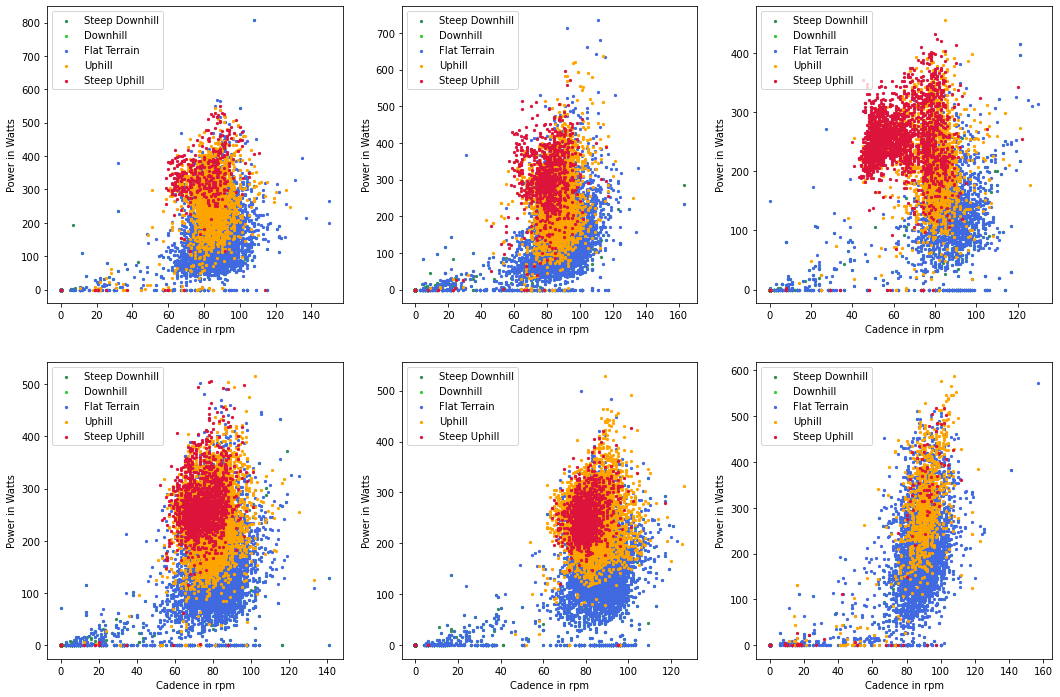

In [34]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
cluster_grade(cad1,pwr1,grd1,ax1)
cluster_grade(cad2,pwr2,grd2,ax2)
cluster_grade(cad3,pwr3,grd3,ax3)
cluster_grade(cad4,pwr4,grd4,ax4)
cluster_grade(cad5,pwr5,grd5,ax5)
cluster_grade(cad6,pwr6,grd6,ax6)

**Next steps:**
- **Problem Setup**: Consider $K$ 2-D Gaussian distributions and the power-cadence data comes from these distributions. The parameters of the $k^{th}$ Gaussian distribution is $\mu_k,\sigma_k^2$. We have a random binary vector $\mathbf{y}_i$ of length $K$ that determines which Gaussian distribution produces the power-cadence data $\mathbf{x}_i\in\mathbb{R}^2$. The power cadence data are in the matrix $\mathbf{X}\in\mathbb{R}^{N\times 2}$ for $N$ number of power-cadence data points. If distribution k produces data i, all coordinates of $\mathbf{y}_i$ are zero except the $k^{th}$ coordinate, which is equal to 1.
- **Likelihood**: $l(\boldsymbol{\theta})=p(\mathbf{x}_1^N,\mathbf{y}_1^N|\boldsymbol{\theta})=\prod_{i=1}^{N}\prod_{k=1}^{K}\big[p(\mathbf{x}_i|\boldsymbol{\theta}_k)\big]^{y_{ik}}$


We want to perform the following steps
- Expectation Maximization algorithm to estimate the $\mu_k,\sigma_k^2$ for $k=2,3,\cdots$, i.e., getting the parameters for the normal distributions for different clusters. We can start with $K=2$ clusters and then later check for $K=3$.
   - Expectation step
   - Maximization step
- Cluster at least one data set and compare the result with whatever, we see from the above plots.

In [35]:
def EM(X):
    mu1 = np.array([60,250])
    mu2 = np.array([100,170])
    K1 = np.array([[50,0],[0,250]])
    K2 = np.array([[50,0],[0,250]])

    count = 0
    tol = 1e-3
    while(1):
        count += 1
        norm1 = st.multivariate_normal(mean=mu1,cov=K1)
        norm2 = st.multivariate_normal(mean=mu2,cov=K2)
        gamma1 = norm1.pdf(X).reshape(-1,1)
        gamma2 = norm2.pdf(X).reshape(-1,1)
        gamma = np.hstack((gamma1,gamma2))
        gamma_prime = gamma/np.sum(gamma,1).reshape(-1,1)

        # Update the mean
        mu1_prime = np.dot(gamma_prime[:,0].T,X)/np.sum(gamma_prime[:,0])
        mu2_prime = np.dot(gamma_prime[:,1].T,X)/np.sum(gamma_prime[:,1])

        # Update the covariance matrices
        K1_prime = np.dot(np.dot((X-mu1).T,np.diag(gamma_prime[:,0])),(X-mu1))
        K2_prime = np.dot(np.dot((X-mu2).T,np.diag(gamma_prime[:,1])),(X-mu2))

        if np.linalg.norm(mu1_prime-mu1)>tol or np.linalg.norm(mu2_prime-mu2)>tol:
            mu1 = mu1_prime; mu2 = mu2_prime
            K1 = K1_prime; K2 = K2_prime
        elif count == 10000:
            print("Iteration count of 10000 reached")
            break
        else:
            break

    print(mu1_prime,mu2_prime)
    return gamma_prime

[ 86.17380586 209.04028074] [ 86.17386727 209.0390956 ]
[ 87.44596164 202.35116822] [ 87.44595698 202.35150342]
[ 75.21216709 208.39449963] [ 75.21215257 208.39462327]
[ 79.18546562 213.45707723] [ 79.18544623 213.45720734]
[ 83.41587287 216.30067128] [ 83.41573376 216.30153072]
[ 88.84608204 235.33432219] [ 88.84633663 235.33335721]


Text(0, 0.5, 'Power (in Watts)')

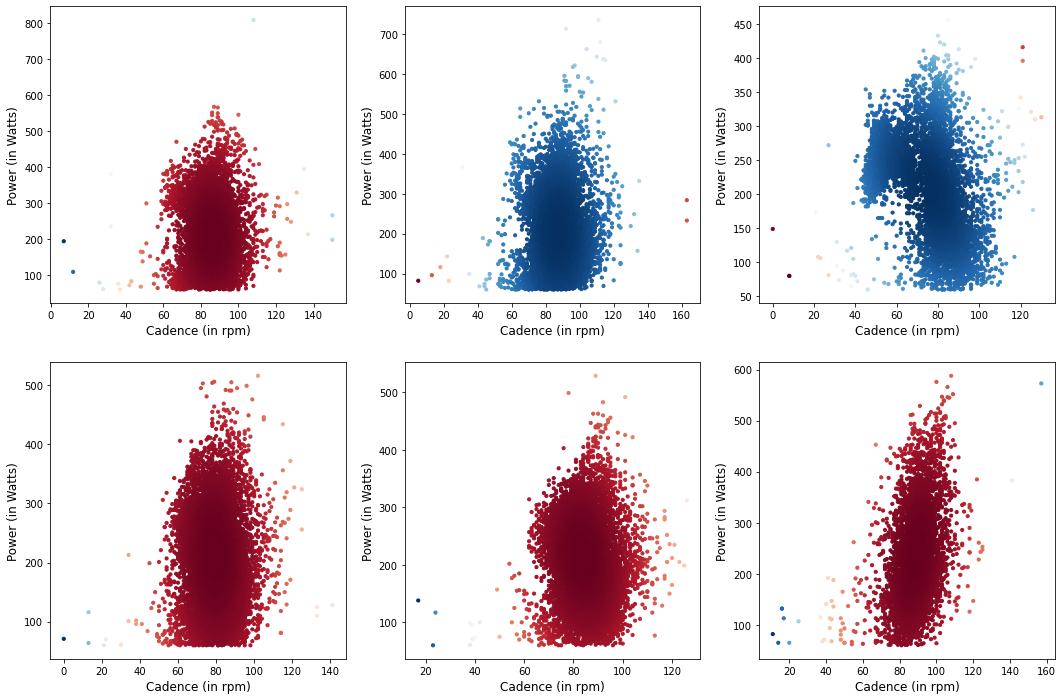

In [36]:
X1 = np.hstack((cad_c1.reshape(-1,1),pwr_c1.reshape(-1,1)))
X2 = np.hstack((cad_c2.reshape(-1,1),pwr_c2.reshape(-1,1)))
X3 = np.hstack((cad_c3.reshape(-1,1),pwr_c3.reshape(-1,1)))
X4 = np.hstack((cad_c4.reshape(-1,1),pwr_c4.reshape(-1,1)))
X5 = np.hstack((cad_c5.reshape(-1,1),pwr_c5.reshape(-1,1)))
X6 = np.hstack((cad_c6.reshape(-1,1),pwr_c6.reshape(-1,1)))

g1 = EM(X1)
g2 = EM(X2)
g3 = EM(X3)
g4 = EM(X4)
g5 = EM(X5)
g6 = EM(X6)


fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(231)
ax1.scatter(X1[:,0],X1[:,1],c=g1[:,0],cmap='RdBu',s=10)
ax1.set_xlabel("Cadence (in rpm)",fontsize=12)
ax1.set_ylabel("Power (in Watts)",fontsize=12)
ax2 = fig.add_subplot(232)
ax2.scatter(X2[:,0],X2[:,1],c=g2[:,0],cmap='RdBu',s=10)
ax2.set_xlabel("Cadence (in rpm)",fontsize=12)
ax2.set_ylabel("Power (in Watts)",fontsize=12)
ax3 = fig.add_subplot(233)
ax3.scatter(X3[:,0],X3[:,1],c=g3[:,0],cmap='RdBu',s=10)
ax3.set_xlabel("Cadence (in rpm)",fontsize=12)
ax3.set_ylabel("Power (in Watts)",fontsize=12)
ax4 = fig.add_subplot(234)
ax4.scatter(X4[:,0],X4[:,1],c=g4[:,0],cmap='RdBu',s=10)
ax4.set_xlabel("Cadence (in rpm)",fontsize=12)
ax4.set_ylabel("Power (in Watts)",fontsize=12)
ax5 = fig.add_subplot(235)
ax5.scatter(X5[:,0],X5[:,1],c=g5[:,0],cmap='RdBu',s=10)
ax5.set_xlabel("Cadence (in rpm)",fontsize=12)
ax5.set_ylabel("Power (in Watts)",fontsize=12)
ax6 = fig.add_subplot(236)
ax6.scatter(X6[:,0],X6[:,1],c=g6[:,0],cmap='RdBu',s=10)
ax6.set_xlabel("Cadence (in rpm)",fontsize=12)
ax6.set_ylabel("Power (in Watts)",fontsize=12)